In [63]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [365]:
# class Value:
  
#   def __init__(self, data, _children=(), _op='', label=''):
#     self.data = data
#     self.grad = 0.0
#     self._backward = lambda: None
#     self._prev = set(_children)
#     self._op = _op
#     self.label = label

#   def __repr__(self):
#     return f"Value(data={self.data})"
  
  
#   def backward(self):
    
#     topo = []
#     visited = set()
#     def build_topo(v):
#       if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#           build_topo(child)
#         topo.append(v)
#     build_topo(self)
    
#     self.grad = 1.0
#     for node in reversed(topo):
#       node._backward()
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [336]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad +=  1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __pow__(self, exponent):
    assert isinstance(exponent, (int, float))
    out = Value(self.data**exponent, (self,), f'**{exponent}')
    def _backward():
      self.grad += exponent * (self.data**(exponent-1)) * out.grad

    self._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      # derivative of e^x is  e^x
      self.grad += out.data * out.grad

    self._backward = _backward 

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other
 
  def __rmul__(self, other):
    return self * other
  
  def backward(self):
    # topological graph
    graph = []
    visited = set()
    def build_graph(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_graph(child)

        graph.append(v)

    build_graph(self)

    self.grad = 1.0 # base case
    for node in reversed(graph):
      node._backward()


In [315]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L



Value(data=-8.0)

In [316]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
        
  build(root)

  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label="{ %s | data %.2f | grad %.2f }" % (n.label, n.data, n.grad,), shape='record', tooltip=n.label)
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

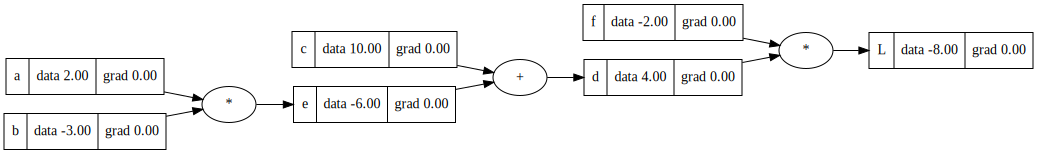

In [317]:

draw_dot(L)


-8.0


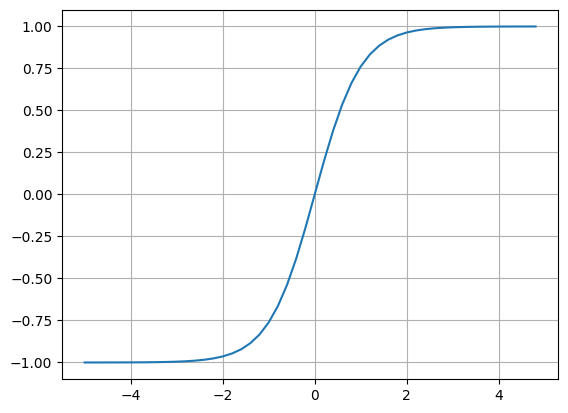

In [318]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); # activation function example


In [319]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'




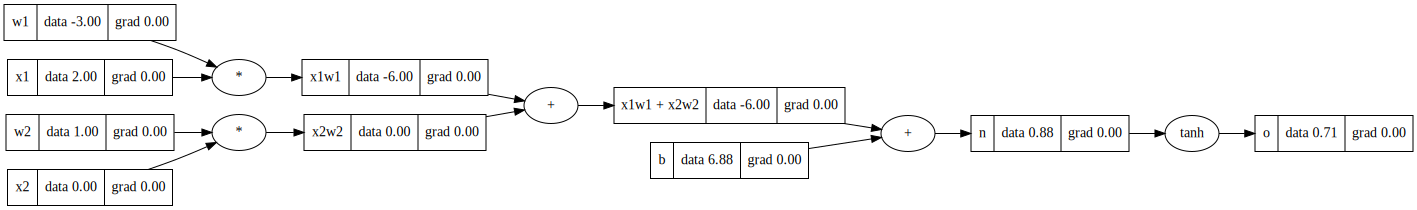

In [320]:

draw_dot(o)

In [321]:

o.grad = 1.0

In [322]:
# o._backward()
o.backward()

In [323]:
n._backward()

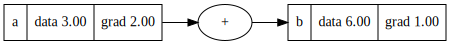

In [324]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

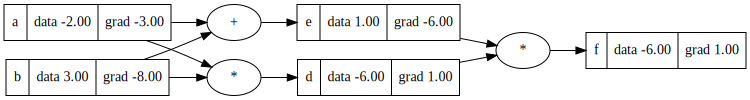

In [325]:

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [326]:
# pytorch example

import torch

# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())


dtype = torch.float
device = torch.device("mps")
device = torch.device("cpu")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

True
True
99 15.352349281311035
199 13.378859519958496
299 12.004023551940918
399 11.045083999633789
499 10.375733375549316
599 9.908180236816406
699 9.581340789794922
799 9.352726936340332
899 9.192708969116211
999 9.080641746520996
1099 9.002110481262207
1199 8.94704532623291
1299 8.908413887023926
1399 8.881305694580078
1499 8.862266540527344
1599 8.848892211914062
1699 8.839491844177246
1799 8.832881927490234
1899 8.82823371887207
1999 8.82496166229248
Result: y = 0.0028548671398311853 + 0.8560400605201721 x + -0.0004925109096802771 x^2 + -0.0932307094335556 x^3


In [327]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7070699720278941
x1 -1.5001561639694192
w1 1.0001041093129461
x2 0.5000520546564731
w2 0.0


In [390]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [ n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x
  
  def predict(self, xs):
    return [ self(x) for x in xs ]

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
# print("ox")
x = [2.0, 3.0]
n = Neuron(2)
n(x)


x = [ 2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

out = n(x)
out.backward()
# draw_dot(out)

In [367]:
ypred = [n(x) for x in xs]
ypred



[Value(data=-0.055877317254692284),
 Value(data=-0.13004689431313127),
 Value(data=-0.03138550658587694),
 Value(data=0.05039454211235439)]

In [393]:

x = [ 2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.2559592713588027)

In [394]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


STEPS = 100
STEP = 0.01

  # return [ n(x) for x in xs ]

loss = 10
for k in range(STEPS):
  # forward pass
  # ypred = [n(x) for x in xs]
  ypred = predict_y()
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # grad 0
  for p in n.parameters():
    p.grad = 0.0

  # backward
  loss.backward()


  for p in n.parameters():
    p.data += -STEP * p.grad

  print(k, loss.data)

print()
# loss.backward()
# draw_dot(loss)


0 3.6711321908841974
1 3.533222546870564
2 3.4125051276378757
3 3.3033965709540167
4 3.2018190146562464
5 3.104912781811991
6 3.0106788609250232
7 2.917693138400715
8 2.824909846285515
9 2.731535369182554
10 2.63695081256712
11 2.540667614370583
12 2.4423065343725563
13 2.3415945201156814
14 2.238376088452271
15 2.132636236258451
16 2.024530783982134
17 1.9144178349295493
18 1.802881402388433
19 1.6907364575906587
20 1.5790053740259857
21 1.468860426036629
22 1.361535584319007
23 1.2582208203668208
24 1.1599590954495516
25 1.0675663947619258
26 0.9815881583870418
27 0.9022946878197622
28 0.8297084858236958
29 0.7636513390478283
30 0.7037986764034505
31 0.6497316423485192
32 0.6009812611800474
33 0.5570625229472876
34 0.5174985683671369
35 0.48183639633488845
36 0.4496559522531798
37 0.4205744060002458
38 0.39424715103862723
39 0.3703667133837386
40 0.3486604367096269
41 0.32888754305799645
42 0.31083596440595807
43 0.2943191923774969
44 0.279173290671824
45 0.2652541461209847
46 0.2524